In [1]:
import pickle
import numpy as np

import multiprocessing
import os
import time
import numpy as np
from scipy.spatial import cKDTree
import open3d as o3d
import util
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from BendLength import BendLengthCalculator
import pickle

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

with open("bend_visualization_data_all.pkl", "rb") as f:
    data = pickle.load(f)

pcd_points = data["pcd_points"]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcd_points)
bend_data = data["bend_data"]
all_normals = data["all_normals"]
segment_indices = data["segment_indices"]
segment_models = data["segment_models"]

# Step 1: Print plane equations
for pid, model in segment_models.items():
    a, b, c, d = model
    print(f"Plane {pid}: {a:.3f}x + {b:.3f}y + {c:.3f}z + {d:.3f} = 0")

# # Step 2: Plot histograms for normals
# import matplotlib.pyplot as plt

# def plot_normals(normals, title):
#     az = np.degrees(np.arctan2(normals[:,1], normals[:,0]))
#     zen = np.degrees(np.arccos(np.clip(normals[:,2], -1, 1)))

#     fig, axs = plt.subplots(1, 2, figsize=(10, 4))
#     axs[0].hist(az, bins=700, color='skyblue', edgecolor='black')
#     axs[0].set_title(f"{title} - Azimuth")
#     axs[1].hist(zen, bins=700, color='salmon', edgecolor='black')
#     axs[1].set_title(f"{title} - Zenith")
#     plt.tight_layout()
#     plt.show()

# # Step 3: Check all planes
# for pid, indices in segment_indices.items():
#     normals = all_normals[indices]
#     if pid == 1:
#         print("First 5 normals from Plane 1:")
#         print(normals[:5])
#     plot_normals(normals, title=f"Plane {pid}")


Plane 0: 0.344x + 0.013y + 0.939z + -1534.868 = 0
Plane 1: 0.905x + 0.057y + -0.422z + -1019.826 = 0
Plane 2: -0.193x + -0.024y + 0.981z + -727.782 = 0
Plane 3: 0.850x + 0.052y + -0.524z + -814.840 = 0
Plane 4: -0.195x + -0.010y + 0.981z + -724.769 = 0
Plane 5: -0.697x + -0.051y + 0.716z + 368.343 = 0
Plane 6: -0.202x + -0.011y + 0.979z + -712.301 = 0
Plane 7: -0.546x + -0.047y + 0.836z + -0.034 = 0
Plane 8: -0.208x + -0.004y + 0.978z + -700.710 = 0
Plane 9: -0.380x + -0.030y + 0.924z + -357.738 = 0
Plane 10: 0.809x + 0.052y + 0.586z + -1889.492 = 0
Plane 11: -0.213x + -0.011y + 0.977z + -691.129 = 0
Plane 12: -0.149x + -0.010y + 0.989z + -796.312 = 0
Plane 13: -0.212x + -0.002y + 0.977z + -694.798 = 0
Plane 14: 0.078x + 0.020y + 0.997z + -1169.489 = 0


In [3]:
plane_2_indices = segment_indices[2]
plane_2_pcd = pcd.select_by_index(plane_2_indices)
o3d.visualization.draw_geometries([plane_2_pcd])


In [9]:
class ArcLengthCalculator:
    def __init__(self, pcd, bend_id, intersection_line, bend_edges, bend_cluster_points, cluster_derivatives, all_normals, segment_indices, inter_step_size=0.5, deriv_step_size=0.2, radius=2.5):
        self.pcd = pcd
        self.points = np.asarray(pcd.points)

        if len(pcd.points) != len(all_normals):
            raise ValueError(f"Mismatch: {len(pcd.points)} points in PCD, but {len(all_normals)} normals loaded. "
                     "Make sure the point cloud is preprocessed the same way.")
        else:
            print(f"Loaded {len(all_normals)} normals for {len(pcd.points)} points in PCD. Proceeding.")

        self.bend_id = bend_id
        self.intersection_line = intersection_line
        self.bend_cluster_points = bend_cluster_points
        self.bend_cluster_kdtree = cKDTree(self.bend_cluster_points)
        self.pcd_kdtree = cKDTree(self.points)
        self.start_point, self.end_point = map(np.array, bend_edges)
        self.bend_cluster_derivatives = cluster_derivatives
        self.all_normals = all_normals
        self.segment_indices = segment_indices
        self.intersection_step_size = inter_step_size     
        self.derivative_step_size = deriv_step_size
        self.radius = 1.4
        self.intersection_it = 0
        self.derivative_it = 0
        self.is_moving_forward = True
        self.past_bend_points = []
        self.edge_projection_points = []

        self.pcd.paint_uniform_color([0.6, 0.6, 0.6])
        self.vis = o3d.visualization.VisualizerWithKeyCallback()
        self.vis.create_window("ArcLengthCalculator")
        self.vis.add_geometry(self.pcd)

        self.vis.register_key_callback(262, self.step_along_intersection)
        self.vis.register_key_callback(265, self.forwardstep_across_derivative)
        self.vis.register_key_callback(264, self.backstep_across_derivative)
    
        self.plane_dominant_bins = {}
        self.past_edge_indices = []

        self.plane_dominant_bins[0] = self.get_dominant_bin_ranges(
                self.all_normals[self.segment_indices[0]],
                threshold=0.2,
                bin_size=1
            )
        
        self.plane_dominant_bins[bend_id] = self.get_dominant_bin_ranges(
                self.all_normals[self.segment_indices[bend_id]],
                threshold=0.2,
                bin_size=1
            )

        self.step_along_intersection(self.vis)

    def plot_histogram_with_dominant_bins(self, angles, bin_edges, dominant_ranges, title, color):
        import matplotlib.pyplot as plt
        counts, edges, bars = plt.hist(angles, bins=bin_edges, color=color, edgecolor='black')
        for i, bar in enumerate(bars):
            bin_start = edges[i]
            bin_end = edges[i+1]
            for dom_start, dom_end in dominant_ranges:
                if np.isclose(bin_start, dom_start, atol=1e-6) and np.isclose(bin_end, dom_end, atol=1e-6):
                    bar.set_color('green')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def get_dominant_bin_ranges(self, normals, threshold=0.2, bin_size=1):
        dominant_bins = {}

        azimuth = np.degrees(np.arctan2(normals[:, 1], normals[:, 0]))
        az_hist, az_edges = np.histogram(azimuth, bins=np.arange(-180, 181, bin_size))
        az_ranges = []
        for i in range(len(az_hist)):
            if az_hist[i] / len(azimuth) > threshold:
                for offset in [-1, 0, 1]:
                    idx = i + offset
                    if 0 <= idx < len(az_hist):
                        az_ranges.append((az_edges[idx], az_edges[idx + 1]))

        zenith = np.degrees(np.arccos(np.clip(normals[:, 2], -1, 1)))
        zen_hist, zen_edges = np.histogram(zenith, bins=np.arange(0, 181, bin_size))
        zen_ranges = []
        for i in range(len(zen_hist)):
            if zen_hist[i] / len(zenith) > threshold:
                for offset in [-2, 0, 2]:
                    idx = i + offset
                    if 0 <= idx < len(zen_hist):
                        zen_ranges.append((zen_edges[idx], zen_edges[idx + 1]))
                        
        dominant_bins["azimuth"] = az_ranges
        dominant_bins["zenith"] = zen_ranges
        self.plot_histogram_with_dominant_bins(azimuth, az_edges, az_ranges, "Azimuth Histogram", color='skyblue')
        self.plot_histogram_with_dominant_bins(zenith, zen_edges, zen_ranges, "Zenith Histogram", color='salmon')

        return dominant_bins

    def is_normal_in_any_bin(self, normal, bin_ranges, mode):
        if mode == "azimuth":
            angle = (np.degrees(np.arctan2(normal[1], normal[0])) + 360) % 360
        elif mode == "zenith":
            angle = np.degrees(np.arccos(np.clip(normal[2], -1, 1)))
        else:
            raise ValueError("Invalid mode: choose 'azimuth' or 'zenith'")
        
        print(f"Angle: {angle} degrees")
        print(f"Bin ranges: {bin_ranges}")
        for start, end in bin_ranges:
            start = (start + 360) % 360
            end = (end + 360) % 360
            if self.angle_in_range(angle, start, end):
                return True
        return False


    def angle_in_range(self, angle, start, end):
        """Checks if angle (in degrees) is inside [start, end], handling wrap-around."""
        angle = (angle + 360) % 360
        start = (start + 360) % 360
        end = (end + 360) % 360
        if start <= end:
            return start <= angle <= end
        else:
            return angle >= start or angle <= end
        
    def check_plane_alignment(self, normal):
        result = {}

        zenith_angle = np.degrees(np.arccos(np.clip(normal[2], -1, 1)))

        for plane_id in [0, self.bend_id]:
            bins = self.plane_dominant_bins[plane_id]
            az_bins = bins.get("azimuth", [])
            zen_bins = bins.get("zenith", [])

            # Always check zenith
            zen_match = self.is_normal_in_any_bin(normal, zen_bins, "zenith") if zen_bins else True

            # Only check azimuth if zenith is not ~0 or ~180
            if 2 < zenith_angle < 178:
                az_match = self.is_normal_in_any_bin(normal, az_bins, "azimuth") if az_bins else True
            else:
                az_match = True  # skip azimuth check for vertical normals

            result[plane_id] = az_match and zen_match

        return result
    
    def find_hemisphere_normal(self, neighborhood_points):
        mean = np.mean(neighborhood_points, axis=0)
        centered = neighborhood_points - mean
        cov = np.cov(centered.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        eig_vecs = eig_vecs[:, np.argsort(eig_vals)]  # ascending order

        pca_normal = eig_vecs[:, 0]  # Smallest eigenvalue → normal direction
        return pca_normal
    
    def align_normals(self, reference_normal, neighbor_directions):
        aligned_normals = np.array(neighbor_directions)
        
        # Check dot product: If negative, flip the normal
        for i in range(len(aligned_normals)):
            if np.dot(reference_normal, aligned_normals[i]) < 0:
                aligned_normals[i] = -aligned_normals[i]

        return aligned_normals
    
    def step_along_intersection(self, vis):
        self.derivative_it = 0
        self.past_bend_points = []
        colors = np.asarray(self.pcd.colors)
        #colors[:] = [0.6, 0.6, 0.6]  # Reset
        self.pcd.colors = o3d.utility.Vector3dVector(colors)
        if hasattr(self, 'line_set'):
            self.vis.remove_geometry(self.line_set)
        
        direction_vector = self.intersection_line[0] / np.linalg.norm(self.intersection_line[0])
        to_end = self.end_point - self.start_point
        if np.dot(direction_vector, to_end) < 0:
            direction_vector *= -1  # Flip if it's pointing toward the wrong side
        
        self.direction_vector = direction_vector
        offset = self.radius
        sampled_point = self.start_point + (offset + self.intersection_it*self.intersection_step_size)*self.direction_vector
        if np.linalg.norm(sampled_point - self.start_point) > np.linalg.norm(self.end_point - self.start_point):
            return
        
        idx = self.bend_cluster_kdtree.query(sampled_point)[1]
        base = self.bend_cluster_points[idx]
        self.base_point = base
        self.last_bend_point = base
        self.past_bend_points.append(base)
        neighbor_indices = self.bend_cluster_kdtree.query_ball_point(base, self.radius)
        neighbor_derivatives = self.bend_cluster_derivatives[neighbor_indices]
        aligned_neighbor_derivatives = self.align_normals(neighbor_derivatives[0], neighbor_derivatives)
        self.current_derivative = np.mean(aligned_neighbor_derivatives, axis=0)
        self.current_derivative /= np.linalg.norm(self.current_derivative)
        self.reference_derivative_direction = self.current_derivative.copy()
        end = base + self.current_derivative * 2
        base = base - self.current_derivative * 2

        self.line_set = self.create_arrow_line(base, end, color=[1, 0, 0])

        self.vis.add_geometry(self.line_set)

        view_ctl = self.vis.get_view_control()
        lookat = sampled_point
        zoom = 0.080000000000000002
        front = [-0.024106890455448116,-0.57254772319971181,0.81951690799604338]
        up =  [0.014828165865396817,0.81946017828866602,0.57294427451208185]
        view_ctl.set_lookat(lookat)  # Set the point the camera is looking at
        view_ctl.set_up(up)      # Set the up direction of the camera
        view_ctl.set_front(front)  # Set the front direction of the camera
        view_ctl.set_zoom(zoom)          # Set the zoom factor of the camera
        self.intersection_it += 1
    
    def step_across_derivative(self, last_bend_point):
        idx = self.pcd_kdtree.query(last_bend_point)[1]
        point = self.points[idx]
        neighbor_bend_indices = self.bend_cluster_kdtree.query_ball_point(point, self.radius)
        if len(neighbor_bend_indices) > 5:
            self.vis.remove_geometry(self.line_set)
            neighbor_derivatives = self.bend_cluster_derivatives[neighbor_bend_indices]
            aligned_neighbor_derivatives = self.align_normals(self.reference_derivative_direction, neighbor_derivatives)
            self.current_derivative = np.mean(aligned_neighbor_derivatives, axis=0)
            self.current_derivative /= np.linalg.norm(self.current_derivative)
            end = point + self.current_derivative * 2
            base = point - self.current_derivative * 2
            self.line_set = self.create_arrow_line(base, end, color=[1, 0, 0])
            self.vis.add_geometry(self.line_set)

        neighbor_all_indices = self.pcd_kdtree.query_ball_point(point, self.radius)
        if len(neighbor_all_indices) > 5:
            neighbor_points = self.points[neighbor_all_indices]

            # HEMISPHERE STRUCTURE
            # vectors = neighbor_points - point
            # dot_products = vectors @ self.reference_derivative_direction
            # forward_mask = dot_products > 0
            # forward_indices = np.array(neighbor_all_indices)[forward_mask]
            # forward_points = self.points[forward_indices]
            # pca_normal = self.find_hemisphere_normal(forward_points)
            # original_normal = self.all_normals[idx]
            # if np.dot(pca_normal, original_normal) < 0:
            #     pca_normal = -pca_normal

            # FORWARD LATERAL SLAB STRUCTURE
            vectors = neighbor_points - point
            dot_products = vectors @ self.current_derivative
            epsilon = 0.35
            mask_1 = np.abs(dot_products) < epsilon
            mask_2 = dot_products > 0
            #final_mask = mask_1
            final_mask = mask_1 & mask_2
            forward_indices = np.array(neighbor_all_indices)[final_mask]
            forward_points = self.points[forward_indices]
            pca_normal = self.find_hemisphere_normal(forward_points)
            original_normal = self.all_normals[idx]
            if np.dot(pca_normal, original_normal) < 0:
                pca_normal = -pca_normal

            alignment = self.check_plane_alignment(pca_normal)
            print(f"Alignment: Plane 0 = {alignment[0]}, Plane 1 = {alignment[self.bend_id]}", flush=True)

            if hasattr(self, 'pca_arrow'):
                self.vis.remove_geometry(self.pca_arrow)
            end = point + pca_normal * 2
            start = point - pca_normal * 2
            self.pca_arrow = self.create_arrow_line(start, end, color=[1.0, 0.2, 1.0])  # purple
            self.vis.add_geometry(self.pca_arrow)

            # end = last_bend_point
            # start = self.past_bend_points[-1]
            # self.bend_points_arrow = self.create_arrow_line(start, end, color=[1.0, 0.0, 0.0])  # blue
            # self.vis.add_geometry(self.bend_points_arrow)

            # Visualize forward-facing neighbors in green
            colors = np.asarray(self.pcd.colors)
            colors[:] = [0.6, 0.6, 0.6]  # reset
            colors[forward_indices] = [0.0, 1.0, 0.0]
            if alignment[0] or alignment[self.bend_id]:
                self.past_edge_indices.append(idx)
                #convert to numpy array for indexing
                temp_numpy_array = np.array(self.past_edge_indices)
                colors[temp_numpy_array] = [1.0, 0.0, 0.0]  # past edge points in red
            else:
                colors[idx] = [1.0, 1.0, 0.0]  # current point in yellow
            self.pcd.colors = o3d.utility.Vector3dVector(colors)


        self.vis.update_geometry(self.pcd)

        view_ctl = self.vis.get_view_control()
        lookat = last_bend_point
        zoom = 0.030000000000000002
        front = [-0.024106890455448116,-0.57254772319971181,0.81951690799604338]
        up =  [0.014828165865396817,0.81946017828866602,0.57294427451208185]
        view_ctl.set_lookat(lookat)  # Set the point the camera is looking at
        view_ctl.set_up(up)      # Set the up direction of the camera
        view_ctl.set_front(front)  # Set the front direction of the camera
        view_ctl.set_zoom(zoom)          # Set the zoom factor of the camera

    def hug_surface(self, last_bend_point, direction_vector): 
        # 1. Find k-NN from the bend cluster (or pcd, if more stable)
        neighbor_indices = self.bend_cluster_kdtree.query(last_bend_point, k=15)[1]
        neighbor_points = self.bend_cluster_points[neighbor_indices]

        # 2. Fit a PCA plane
        mean = np.mean(neighbor_points, axis=0)
        centered = neighbor_points - mean
        cov = np.cov(centered.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        eig_vecs = eig_vecs[:, np.argsort(eig_vals)]
        pca_normal = eig_vecs[:, 0]  # Normal to the surface

        # Flip the normal if it's facing the wrong way
        vec_to_point = last_bend_point - mean
        if np.dot(vec_to_point, pca_normal) < 0:
            pca_normal = -pca_normal

        # 3. Project the raw point onto the PCA plane
        distance = np.dot(vec_to_point, pca_normal)
        projected_point = last_bend_point - distance * pca_normal

        # 4. Constrain the correction to be perpendicular to the derivative direction
        correction_vec = projected_point - last_bend_point
        perp_component = correction_vec - np.dot(correction_vec, direction_vector) * direction_vector

        # 5. Apply only the perpendicular correction
        final_point = last_bend_point + perp_component

        return final_point
    
    def forwardstep_across_derivative(self, vis):
        if not self.is_moving_forward:
            self.reference_derivative_direction *= -1
            self.is_moving_forward = True
        step_dir = self.current_derivative
        last_bend_point_temp = self.last_bend_point + self.derivative_step_size * step_dir
        projected = self.hug_surface(last_bend_point_temp, step_dir)
        self.visualize_projection_step(last_bend_point_temp, projected)
        self.last_bend_point = projected
        self.step_across_derivative(self.last_bend_point)

    def backstep_across_derivative(self, vis):
        if self.is_moving_forward:
            self.reference_derivative_direction *= -1
            self.is_moving_forward = False
        step_dir = -self.current_derivative
        last_bend_point_temp = self.last_bend_point + self.derivative_step_size * step_dir
        projected = self.hug_surface(last_bend_point_temp, step_dir)
        self.visualize_projection_step(last_bend_point_temp, projected)
        self.last_bend_point = projected
        self.step_across_derivative(self.last_bend_point)


    def visualize_projection_step(self, raw_point, projected_point):
        """
        Visualizes the raw stepped point and its projection as colored points and a connecting arrow.
        - raw_point: original point before hugging (blue)
        - projected_point: corrected point on surface (magenta)
        """

        # Blue → original step point
        raw_pcd = o3d.geometry.PointCloud()
        raw_pcd.points = o3d.utility.Vector3dVector([raw_point])
        raw_pcd.colors = o3d.utility.Vector3dVector([[0.2, 0.2, 1.0]])  # Blue

        # Magenta → projection
        proj_pcd = o3d.geometry.PointCloud()
        proj_pcd.points = o3d.utility.Vector3dVector([projected_point])
        proj_pcd.colors = o3d.utility.Vector3dVector([[1.0, 0.0, 1.0]])  # Magenta

        # Connecting arrow
        arrow = self.create_arrow_line(raw_point, projected_point, color=[0.2, 0.2, 1.0])  # Blue line

        self.vis.add_geometry(raw_pcd)
        self.vis.add_geometry(proj_pcd)
        self.vis.add_geometry(arrow)

        view_ctl = self.vis.get_view_control()
        lookat = projected_point
        zoom = 0.030000000000000002
        front = [-0.024106890455448116,-0.57254772319971181,0.81951690799604338]
        up =  [0.014828165865396817,0.81946017828866602,0.57294427451208185]
        view_ctl.set_lookat(lookat)  # Set the point the camera is looking at
        view_ctl.set_up(up)      # Set the up direction of the camera
        view_ctl.set_front(front)  # Set the front direction of the camera
        view_ctl.set_zoom(zoom)          # Set the zoom factor of the camera

    def create_arrow_line(self, start, end, color):
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector([start, end])
        line_set.lines = o3d.utility.Vector2iVector([[0, 1]])
        line_set.colors = o3d.utility.Vector3dVector([color])
        return line_set

    def run(self):
        self.vis.run()
        self.vis.destroy_window()


Processing bend ID: 1
Loaded 275111 normals for 275111 points in PCD. Proceeding.


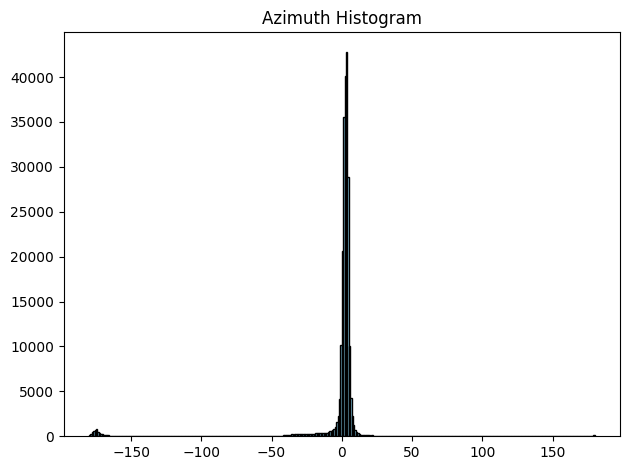

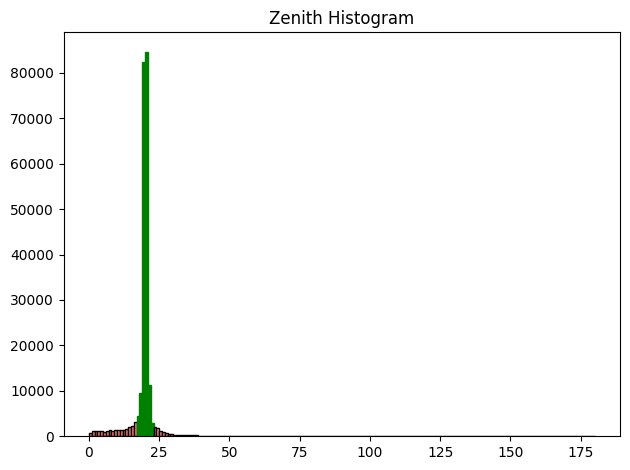

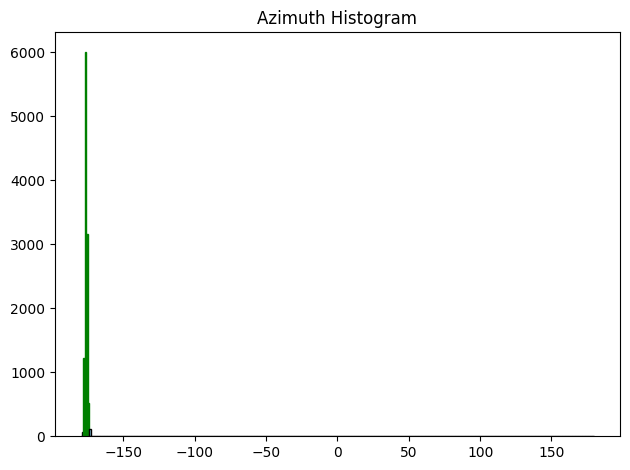

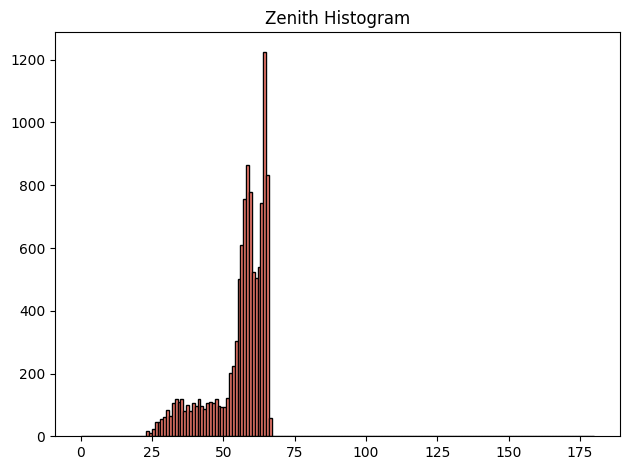

Angle: 6.5337157754187265 degrees
Bin ranges: [(17, 18), (19, 20), (21, 22), (18, 19), (20, 21), (22, 23)]
Angle: 351.94251540866145 degrees
Bin ranges: [(-178, -177), (-177, -176), (-176, -175), (-177, -176), (-176, -175), (-175, -174)]
Alignment: Plane 0 = False, Plane 1 = False
Angle: 13.306067369436335 degrees
Bin ranges: [(17, 18), (19, 20), (21, 22), (18, 19), (20, 21), (22, 23)]
Angle: 359.7465726587407 degrees
Bin ranges: [(-178, -177), (-177, -176), (-176, -175), (-177, -176), (-176, -175), (-175, -174)]
Alignment: Plane 0 = False, Plane 1 = False
Angle: 4.62415424138457 degrees
Bin ranges: [(17, 18), (19, 20), (21, 22), (18, 19), (20, 21), (22, 23)]
Angle: 195.08221259448436 degrees
Bin ranges: [(-178, -177), (-177, -176), (-176, -175), (-177, -176), (-176, -175), (-175, -174)]
Alignment: Plane 0 = False, Plane 1 = False
Angle: 21.61945588817427 degrees
Bin ranges: [(17, 18), (19, 20), (21, 22), (18, 19), (20, 21), (22, 23)]
Angle: 3.1697662489504523 degrees
Bin ranges: [(-17

In [10]:
for bend_id, bend_info in bend_data.items():
    print(f"\nProcessing bend ID: {bend_id}")
    calculator = ArcLengthCalculator(
        pcd=pcd,
        bend_id=bend_id,
        intersection_line=bend_info["intersection_line"],
        bend_edges=bend_info["bend_edges"],
        bend_cluster_points=bend_info["cluster_points"],
        cluster_derivatives=bend_info["cluster_derivatives"],
        all_normals=all_normals,
        segment_indices=segment_indices)
    
    calculator.run()
    
    break